In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt

columns = ["filename", "classname"]

# BASE = "./data"
BASE = "/content/drive/MyDrive/Colab Notebooks/data/preprocessed"
data_csv_file = os.path.join(BASE, "data.csv")
data_folder = os.path.join(BASE, "images")
#root_folder = os.path.join(BASE, "/")

data_df = pd.read_csv(data_csv_file, skiprows=1, names=columns)
#print(len(data_df))

In [3]:
# get image data
def getImageData(folder, image_file):
    return Image.open(os.path.join(folder, image_file)).convert('RGB') # Load the image

# create directory
def make_dir(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)

model_path = os.path.join(BASE, 'model', 'face_mask_detection.pth')
# make_dir(model_path)

# predefined classes
classes = {
    "mask_colorful": 0,
    "face_no_mask": 1,
    "mask_surgical": 2,
    "ffp2_mask": 3
}


In [4]:
class FaceMaskDataset(Dataset):
    dataset = []
    conversion = None

    def __init__(self, indexes, conversion=transforms.ToTensor()):
        self.conversion = conversion
        for rowIndex in indexes:
            sample = {}
            sample['image'] = getImageData(data_folder, data_df[columns[0]][rowIndex])
            sample['target'] = classes[data_df[columns[1]][rowIndex]]
            self.dataset.append(sample)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image = self.dataset[index]['image']
        if self.conversion is not None:
            image = self.conversion(image)
        return image, self.dataset[index]['target']

In [5]:
"""train_split_percentage = 0.75
val_split_percentage = 0.15
test_split_percentage = 0.1"""
size_of_the_dataset = int(data_df.shape[0]/10)


print("size_of_the_dataset", size_of_the_dataset)

batch_size = 25
num_of_classes = len(classes.keys())

indexes = list(range(size_of_the_dataset))
random.shuffle(indexes)
print(len(indexes))

"""
train_indexes = indexes[:int(train_split_percentage*len(indexes))]
val_indexes = indexes[int(train_split_percentage*len(indexes))                      :int((train_split_percentage + val_split_percentage)*len(indexes))]
test_indexes = indexes[int(
    (train_split_percentage + val_split_percentage)*len(indexes)):]


print(f"Effective train split = {len(train_indexes)/len(indexes)*100}%")
print(f"Effective val split = {len(val_indexes)/len(indexes)*100}%")
print(f"Effective test split = {len(test_indexes)/len(indexes)*100}%")"""

size_of_the_dataset 133
133


'\ntrain_indexes = indexes[:int(train_split_percentage*len(indexes))]\nval_indexes = indexes[int(train_split_percentage*len(indexes))                      :int((train_split_percentage + val_split_percentage)*len(indexes))]\ntest_indexes = indexes[int(\n    (train_split_percentage + val_split_percentage)*len(indexes)):]\n\n\nprint(f"Effective train split = {len(train_indexes)/len(indexes)*100}%")\nprint(f"Effective val split = {len(val_indexes)/len(indexes)*100}%")\nprint(f"Effective test split = {len(test_indexes)/len(indexes)*100}%")'

In [6]:
transform = transforms.Compose(
    [transforms.Resize((250, 250)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                       std=[0.229, 0.224, 0.225])])

In [7]:
print("Loading dataset")
dataset = FaceMaskDataset(indexes, conversion=transform)

Loading dataset


In [ ]:
"""print("Loading training set")
train_dataset = FaceMaskDataset(train_indexes, conversion=transform)
print("Loading validation set")
val_dataset = FaceMaskDataset(val_indexes, conversion=transform)
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)"""

'print("Loading training set")\ntrain_dataset = FaceMaskDataset(train_indexes, conversion=transform)\nprint("Loading validation set")\nval_dataset = FaceMaskDataset(val_indexes, conversion=transform)\ntrain_loader = torch.utils.data.DataLoader(\n    dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)\nval_loader = torch.utils.data.DataLoader(\n    dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)'

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [9]:
import torch.nn as nn
import torch.nn.functional as F

class FaceMaskClassificationBase(nn.Module):
    train_correct = 0
    def training_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        scores, predictions = torch.max(out.data, 1)
        train_correct = (predictions == labels).sum().item()
        return loss, train_correct
    
    def validation_step(self, batch):
        images, labels = batch 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_accuracy: {:.4f}".format(
            epoch+1, result['train_loss'], result['train_accuracy']))

In [10]:
class CNN(FaceMaskClassificationBase):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(246016, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, num_of_classes),
        )

    def forward(self, x):
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x


In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, history, opt_func = torch.optim.SGD):
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        train_correct = 0
        for batch in train_loader:
            images, labels = batch
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            loss, correct = model.training_step(batch)
            # update-training-loss
            train_losses.append(loss)

            train_correct += correct
            # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
            # perform-a-single-optimization-step (parameter-update)
            optimizer.step()
            # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
            
        #result = evaluate(model, val_loader)
        result = {}
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = train_correct / len(train_loader.dataset) * 100

        history['train_loss'].append(result['train_loss'])
        history['train_accuracy'].append(result['train_accuracy'])

        model.epoch_end(epoch, result)
        #history.append(result)
    
    return history

In [12]:
model = CNN()
model = model.to(device)

In [13]:
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [31]:
def KFold_creator(model,dataset,batch_size,device):
  kfold = KFold(n_splits=10, shuffle=True,random_state=None)
  fold_value = 1;
  foldperf={}
  for fold, (train_idx,test_idx) in enumerate(kfold.split(dataset)):
    print('Fold {}'.format(fold + 1))
    train_data = Subset(dataset,train_idx)
    test_data = Subset(dataset,test_idx)

    train_loader = torch.utils.data.DataLoader(dataset=train_data,batch_size=batch_size,num_workers=0,shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_data,batch_size=batch_size,num_workers=0,shuffle=True)
    
    model.apply(reset_weights)

    history = {'train_loss': [], 'test_loss': 0,'train_accuracy':[],'test_accuracy': 0}


    history = fit(10, 0.001, model, train_loader, history, torch.optim.Adam)
    history = test_phase(model,test_loader,device,history)

    foldperf['fold{}'.format(fold+1)] = history   
  
  return foldperf

In [32]:
foldperf = KFold_creator(model,dataset,batch_size,device)

Fold 1
Epoch [1], train_loss: 17.8277, train_accuracy: 36.9748
Epoch [2], train_loss: 6.5714, train_accuracy: 50.4202
Epoch [3], train_loss: 2.8034, train_accuracy: 49.5798
Epoch [4], train_loss: 0.8231, train_accuracy: 65.5462
Epoch [5], train_loss: 0.8509, train_accuracy: 65.5462
Epoch [6], train_loss: 0.5559, train_accuracy: 82.3529
Epoch [7], train_loss: 0.4800, train_accuracy: 84.8739
Epoch [8], train_loss: 0.3175, train_accuracy: 91.5966
Epoch [9], train_loss: 0.1824, train_accuracy: 97.4790
Epoch [10], train_loss: 0.1227, train_accuracy: 97.4790
Test loss of the model: 6.0186 %
Test Accuracy of the model: 21.428571428571427 %
              precision    recall  f1-score   support

         0.0       0.33      0.20      0.25         5
         1.0       0.33      0.40      0.36         5
         2.0       0.00      0.00      0.00         4

    accuracy                           0.21        14
   macro avg       0.22      0.20      0.20        14
weighted avg       0.24      0.21

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

Epoch [1], train_loss: 37.6628, train_accuracy: 35.0000
Epoch [2], train_loss: 5.4194, train_accuracy: 45.8333
Epoch [3], train_loss: 2.6535, train_accuracy: 38.3333
Epoch [4], train_loss: 1.2388, train_accuracy: 55.8333
Epoch [5], train_loss: 0.8511, train_accuracy: 67.5000
Epoch [6], train_loss: 0.6674, train_accuracy: 75.8333
Epoch [7], train_loss: 0.5358, train_accuracy: 82.5000
Epoch [8], train_loss: 0.3204, train_accuracy: 97.5000
Epoch [9], train_loss: 0.1324, train_accuracy: 98.3333
Epoch [10], train_loss: 0.1070, train_accuracy: 97.5000
Test loss of the model: 4.7099 %
Test Accuracy of the model: 38.46153846153847 %
              precision    recall  f1-score   support

         0.0       0.25      0.25      0.25         4
         1.0       0.43      0.60      0.50         5
         2.0       0.50      0.25      0.33         4

    accuracy                           0.38        13
   macro avg       0.39      0.37      0.36        13
weighted avg       0.40      0.38      0.

In [33]:
testLoss,trainLoss,testAccuracy,trainAccuracy=[],[],[],[]
k=10
for f in range(1,k+1):
  trainLoss.append(np.mean(foldperf['fold{}'.format(f)]['train_loss']))
  #testl_f.append(foldperf['fold{}'.format(f)]['test_loss'])
  trainAccuracy.append(np.mean(foldperf['fold{}'.format(f)]['train_accuracy']))
  #testa_f.append(foldperf['fold{}'.format(f)]['test_accuracy'])
  testLoss.append(foldperf['fold{}'.format(f)]['test_loss'])
  testAccuracy.append(foldperf['fold{}'.format(f)]['test_accuracy'])

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.4f} \t Average Test Loss: {:.4f} \t Average Training Acc: {:.4f} \t Average Test Acc: {:.4f}".format(np.mean(trainLoss),sum(testLoss)/k,np.mean(trainAccuracy),sum(testAccuracy)/k))     

Performance of 10 fold cross validation
Average Training Loss: 3.7538 	 Average Test Loss: 4.2476 	 Average Training Acc: 68.5669 	 Average Test Acc: 33.1319


In [ ]:
#history = fit(50, 0.001, model, train_loader, val_loader, torch.optim.Adam)

torch.save(model, model_path)

Epoch [1], train_loss: 14.3057, val_loss: 1.3502, val_acc: 0.3803
Epoch [2], train_loss: 1.3955, val_loss: 1.1948, val_acc: 0.4778
Epoch [3], train_loss: 1.2612, val_loss: 1.1163, val_acc: 0.5513
Epoch [4], train_loss: 1.2098, val_loss: 1.0900, val_acc: 0.5246
Epoch [5], train_loss: 1.1410, val_loss: 0.9741, val_acc: 0.6314
Epoch [6], train_loss: 1.0009, val_loss: 0.8534, val_acc: 0.6221
Epoch [7], train_loss: 0.9285, val_loss: 0.7459, val_acc: 0.7132
Epoch [8], train_loss: 0.8186, val_loss: 0.5815, val_acc: 0.7823
Epoch [9], train_loss: 0.6474, val_loss: 0.4870, val_acc: 0.8208
Epoch [10], train_loss: 0.5995, val_loss: 0.4170, val_acc: 0.8649
Epoch [11], train_loss: 0.5451, val_loss: 0.3929, val_acc: 0.8574
Epoch [12], train_loss: 0.4802, val_loss: 0.4577, val_acc: 0.8190
Epoch [13], train_loss: 0.3649, val_loss: 0.2160, val_acc: 0.9241
Epoch [14], train_loss: 0.3161, val_loss: 0.2211, val_acc: 0.9241
Epoch [15], train_loss: 0.2896, val_loss: 0.2153, val_acc: 0.9150
Epoch [16], train_

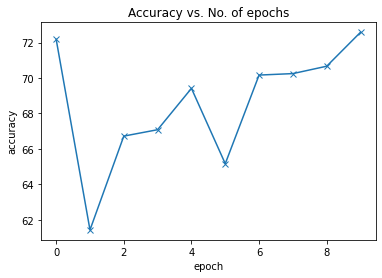

In [34]:
import matplotlib.pyplot as plt

def plot_accuracies(history):
    """ Plot the history of accuracies"""
    #accuracies = [x['val_acc'] for x in history]
    plt.plot(history, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    

plot_accuracies(trainAccuracy)

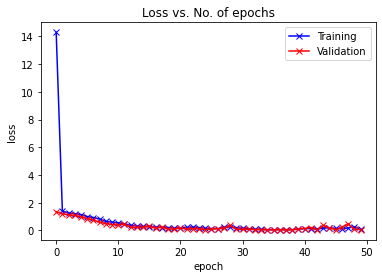

In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [ ]:
import copy
model.load_state_dict(copy.deepcopy(torch.load(model_path, device)))
model.eval()

AttributeError: ignored

In [ ]:
"""test_dataset = FaceMaskDataset(test_indexes, conversion=transform)
print("Loading test set")
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)"""

Loading test set


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def test_phase(model,test_loader, device, history):

  y_true = torch.tensor([])
  y_true = y_true.to(device)
  y_preds = torch.tensor([])
  y_preds = y_preds.to(device)

  # test-the-model
  model.eval()  # it-disables-dropout
  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
          y_true = torch.cat(
              (y_true, labels)
          )
          outputs = model(images)

          loss = F.cross_entropy(outputs, labels) # Calculate loss
          scores, predicted = torch.max(outputs.data, 1)
          

          #_, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          y_preds = torch.cat(
              (y_preds, predicted)
          )

      test_accuracy = correct / total * 100
      print('Test loss of the model: {:.4f} %'.format(loss)) 
      print('Test Accuracy of the model: {} %'.format(test_accuracy))

      history['test_loss'] = loss
      history['test_accuracy'] = test_accuracy


  y_true = y_true.to('cpu')
  y_preds = y_preds.to('cpu')
  #matrix = confusion_matrix(y_true, y_preds)
  #plt.figure(figsize = (10,7))
  #ax = sns.heatmap(matrix, fmt='', annot=True, cmap='Blues')
  #ax.set_title('Confusion Matrix with labels!!');
  #ax.set_xlabel('Predicted Mask Type')
  #ax.set_ylabel('Actual Mask Type')
  #ax.xaxis.set_ticklabels([i for i in classes.keys()])
  #ax.yaxis.set_ticklabels([i for i in classes.keys()])
  #plt.show()

  from sklearn.metrics import precision_recall_fscore_support as score
  precision, recall, fscore, support = score(y_true, y_preds)
  print(classification_report(y_true,y_preds))

  return history

In [ ]:
def label_to_classname(label):
  for classname in classes.keys():
    if classes[classname] == label:
      return classname
  return 'NULL'

In [ ]:
new_images_path = os.path.join(BASE, "test")

new_images = os.listdir(new_images_path)

with torch.no_grad():
    for image in new_images:
      file_name = image
      image = transform(Image.open(os.path.join(new_images_path, image)).convert('RGB'))
      # image = image.unsqueeze(1)
      image = image.unsqueeze(0)
      image = image.to(device)
      labels = model(image)
      _, predicted = torch.max(labels.data, 1)
      print(f'{file_name} file is {label_to_classname(predicted[0])}')


0748.jpg file is mask_surgical
1.jpg file is mask_surgical
4.jpg file is mask_surgical
3.png file is ffp2_mask
cloth_mask.jpg file is mask_colorful
without_mask.jpg file is face_no_mask
n95_mask.jpg file is mask_surgical


In [ ]:
# transform = transforms.Compose(
#     [transforms.Resize((100, 100)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# new_data_folder = "./data/new/images"

# tensor_image = transforms.ToPILImage()(transform(Image.open(os.path.join(new_data_folder, '1.png'))))

# import matplotlib.pyplot as plt

# plt.imshow(tensor_image)
# plt.show()